In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
import yfinance as yf
from scipy.stats import norm, t

In [16]:
# Function to get stock data
def fetch_stock_data(ticker_list, start_date, end_date):
    """
    Fetch historical data for the given stock tickers between start_date and end_date.
    Returns the percentage returns, mean returns, and covariance matrix of the stocks.
    """
    stock_data = yf.download(ticker_list, start=start_date, end=end_date)
    stock_data = stock_data['Close']
    pct_returns = stock_data.pct_change()
    mean_returns = pct_returns.mean()
    cov_matrix = pct_returns.cov()
    return pct_returns, mean_returns, cov_matrix

In [17]:
# Function to calculate portfolio performance
def calc_portfolio_performance(asset_weights, avg_returns, covariance_matrix, time_period):
    """
    Calculate expected portfolio returns and standard deviation given weights, mean returns,
    covariance matrix, and time period.
    """
    expected_return = np.sum(avg_returns * asset_weights) * time_period
    expected_std_dev = np.sqrt(np.dot(asset_weights.T, np.dot(covariance_matrix, asset_weights))) * np.sqrt(time_period)
    return expected_return, expected_std_dev

In [18]:
# Define your portfolio stocks
portfolio_stocks = ['NVDA', 'KSPI', 'SVOL', 'NEE', 'RYCEY', 'CASY']

# Define the quantities and purchase prices of your stocks
stock_purchase_data = {
    'NVDA': {'quantity': 310, 'purchase_price': 110.95},
    'KSPI': {'quantity': 104, 'purchase_price': 115.02},
    'SVOL': {'quantity': 507, 'purchase_price': 22.14},
    'NEE': {'quantity': 77, 'purchase_price': 73.69},
    'RYCEY': {'quantity': 1800, 'purchase_price': 5},
    'CASY': {'quantity': 33, 'purchase_price': 332.47}
}

# Define the date range for historical data
end_date = dt.datetime.now()
start_date = end_date - dt.timedelta(days=800)

# Fetch data
pct_returns, avg_returns, cov_matrix = fetch_stock_data(portfolio_stocks, start_date=start_date, end_date=end_date)
pct_returns = pct_returns.dropna()

# Calculate initial investment and weights based on purchase data
initial_investment = sum(stock_purchase_data[stock]['quantity'] * stock_purchase_data[stock]['purchase_price'] for stock in portfolio_stocks)
asset_weights = np.array([stock_purchase_data[stock]['quantity'] * stock_purchase_data[stock]['purchase_price'] for stock in portfolio_stocks])
asset_weights /= np.sum(asset_weights)

# Calculate portfolio returns
pct_returns['portfolio'] = pct_returns.dot(asset_weights)

[*********************100%%**********************]  6 of 6 completed


In [19]:
# Function to calculate historical Value at Risk (VaR)
def calculate_historical_var(returns, alpha=5):
    """
    Calculate historical Value at Risk (VaR) for a given confidence level (alpha).
    """
    if isinstance(returns, pd.Series):
        return np.percentile(returns, alpha)
    elif isinstance(returns, pd.DataFrame):
        return returns.aggregate(calculate_historical_var, alpha=alpha)
    else:
        raise TypeError("Expected returns to be dataframe or series")

In [20]:
# Function to calculate historical Conditional Value at Risk (CVaR)
def calculate_historical_cvar(returns, alpha=5):
    """
    Calculate historical Conditional Value at Risk (CVaR) for a given confidence level (alpha).
    """
    if isinstance(returns, pd.Series):
        below_var = returns <= calculate_historical_var(returns, alpha=alpha)
        return returns[below_var].mean()
    elif isinstance(returns, pd.DataFrame):
        return returns.aggregate(calculate_historical_cvar, alpha=alpha)
    else:
        raise TypeError("Expected returns to be dataframe or series")

In [21]:
# Define time period for Monte Carlo simulation
time_period = 100

# Calculate historical VaR and CVaR
historical_var = -calculate_historical_var(pct_returns['portfolio'], alpha=5) * np.sqrt(time_period)
historical_cvar = -calculate_historical_cvar(pct_returns['portfolio'], alpha=5) * np.sqrt(time_period)

# Calculate portfolio performance
portfolio_return, portfolio_std_dev = calc_portfolio_performance(asset_weights, avg_returns, cov_matrix, time_period)

# Print portfolio return and risk metrics
print('Expected Portfolio Return:      ', round(initial_investment * portfolio_return, 2))
print('Value at Risk 95th CI    :      ', round(initial_investment * historical_var, 2))
print('Conditional VaR 95th CI  :      ', round(initial_investment * historical_cvar, 2))

Expected Portfolio Return:       12670.22
Value at Risk 95th CI    :       10448.57
Conditional VaR 95th CI  :       14560.56


In [22]:
# Function to calculate parametric VaR
def calculate_parametric_var(portfolio_return, portfolio_std_dev, distribution='normal', alpha=5, dof=6):
    """
    Calculate parametric VaR for given portfolio returns, standard deviation,
    distribution type (normal or t-distribution), confidence level (alpha), and degrees of freedom (dof).
    """
    if distribution == 'normal':
        var = norm.ppf(1 - alpha / 100) * portfolio_std_dev - portfolio_return
    elif distribution == 't-distribution':
        nu = dof
        var = np.sqrt((nu - 2) / nu) * t.ppf(1 - alpha / 100, nu) * portfolio_std_dev - portfolio_return
    else:
        raise TypeError("Expected distribution type 'normal'/'t-distribution'")
    return var

In [23]:
# Function to calculate parametric CVaR
def calculate_parametric_cvar(portfolio_return, portfolio_std_dev, distribution='normal', alpha=5, dof=6):
    """
    Calculate parametric CVaR for given portfolio returns, standard deviation,
    distribution type (normal or t-distribution), confidence level (alpha), and degrees of freedom (dof).
    """
    if distribution == 'normal':
        cvar = (alpha / 100) ** -1 * norm.pdf(norm.ppf(alpha / 100)) * portfolio_std_dev - portfolio_return
    elif distribution == 't-distribution':
        nu = dof
        xanu = t.ppf(alpha / 100, nu)
        cvar = -1 / (alpha / 100) * (1 - nu) ** (-1) * (nu - 2 + xanu ** 2) * t.pdf(xanu, nu) * portfolio_std_dev - portfolio_return
    else:
        raise TypeError("Expected distribution type 'normal'/'t-distribution'")
    return cvar

Normal VaR 95th CI       :       2958.19
Normal CVaR 95th CI      :       6928.44
t-dist VaR 95th CI       :       2404.7
t-dist CVaR 95th CI      :       7816.37


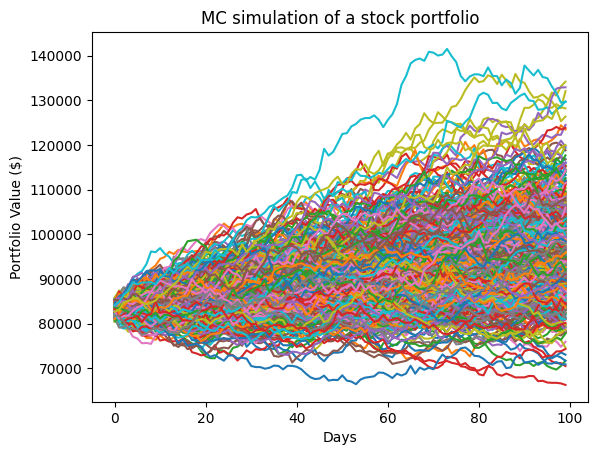

In [24]:
# Calculate parametric VaR and CVaR
normal_var = calculate_parametric_var(portfolio_return, portfolio_std_dev)
normal_cvar = calculate_parametric_cvar(portfolio_return, portfolio_std_dev)

t_dist_var = calculate_parametric_var(portfolio_return, portfolio_std_dev, distribution='t-distribution')
t_dist_cvar = calculate_parametric_cvar(portfolio_return, portfolio_std_dev, distribution='t-distribution')

# Print parametric VaR and CVaR
print("Normal VaR 95th CI       :      ", round(initial_investment * normal_var, 2))
print("Normal CVaR 95th CI      :      ", round(initial_investment * normal_cvar, 2))
print("t-dist VaR 95th CI       :      ", round(initial_investment * t_dist_var, 2))
print("t-dist CVaR 95th CI      :      ", round(initial_investment * t_dist_cvar, 2))

# Monte Carlo Method
num_simulations = 400  # number of simulations
timeframe = 100  # timeframe in days

mean_matrix = np.full(shape=(timeframe, len(asset_weights)), fill_value=avg_returns)
mean_matrix = mean_matrix.T

simulated_portfolios = np.full(shape=(timeframe, num_simulations), fill_value=0.0)

initial_portfolio_value = initial_investment

for simulation in range(0, num_simulations):
    # Monte Carlo simulation loop
    random_values = np.random.normal(size=(timeframe, len(asset_weights)))
    cholesky_matrix = np.linalg.cholesky(cov_matrix)
    daily_returns = mean_matrix + np.inner(cholesky_matrix, random_values)
    simulated_portfolios[:, simulation] = np.cumprod(np.inner(asset_weights, daily_returns.T) + 1) * initial_portfolio_value

# Plot the Monte Carlo simulation results
plt.plot(simulated_portfolios)
plt.ylabel('Portfolio Value ($)')
plt.xlabel('Days')
plt.title('MC simulation of a stock portfolio')
plt.show()

In [25]:
# Function to calculate VaR from Monte Carlo simulation
def calculate_mc_var(simulated_returns, alpha=5):
    """
    Calculate VaR from Monte Carlo simulation results.
    """
    if isinstance(simulated_returns, pd.Series):
        return np.percentile(simulated_returns, alpha)
    else:
        raise TypeError("Expected a pandas data series.")

In [26]:
# Function to calculate CVaR from Monte Carlo simulation
def calculate_mc_cvar(simulated_returns, alpha=5):
    """
    Calculate CVaR from Monte Carlo simulation results.
    """
    if isinstance(simulated_returns, pd.Series):
        below_var = simulated_returns <= calculate_mc_var(simulated_returns, alpha=alpha)
        return simulated_returns[below_var].mean()
    else:
        raise TypeError("Expected a pandas data series.")

In [27]:
# Calculate Monte Carlo VaR and CVaR
portfolio_results = pd.Series(simulated_portfolios[-1, :])

mc_var = initial_portfolio_value - calculate_mc_var(portfolio_results, alpha=5)
mc_cvar = initial_portfolio_value - calculate_mc_cvar(portfolio_results, alpha=5)

# Print Monte Carlo VaR and CVaR
print('VaR ${}'.format(round(mc_var, 2)))
print('CVaR ${}'.format(round(mc_cvar, 2)))
print("\nInterpretation of Monte Carlo VaR and CVaR:")
print("VaR: With 95% confidence, the most you could expect to lose in a day is ${}.".format(round(mc_var, 2)))
print("CVaR: If the worst 5% of losses occur, you could expect to lose an average of ${}.".format(round(mc_cvar, 2)))

# Print all VaR results
print("\nVaR:")
print(' historical VaR 95th CI   :      ', round(initial_investment * historical_var, 2))
print(" Normal VaR 95th CI       :      ", round(initial_investment * normal_var, 2))
print(" t-dist VaR 95th CI       :      ", round(initial_investment * t_dist_var, 2))
print(" MC VaR  95th CI          :      ", round(mc_var, 2))
print("\nInterpretation of VaR results:")
print("Historical VaR: Based on historical data, the most you could expect to lose in a day is ${} with 95% confidence.".format(round(initial_investment * historical_var, 2)))
print("Normal VaR: Assuming a normal distribution, the most you could expect to lose in a day is ${} with 95% confidence.".format(round(initial_investment * normal_var, 2)))
print("t-distribution VaR: Assuming a t-distribution, the most you could expect to lose in a day is ${} with 95% confidence.".format(round(initial_investment * t_dist_var, 2)))
print("Monte Carlo VaR: Based on the Monte Carlo simulation, the most you could expect to lose in a day is ${} with 95% confidence.".format(round(mc_var, 2)))

# Print all CVaR results
print("\nCVaR:")
print(' historical CVaR 95th CI  :      ', round(initial_investment * historical_cvar, 2))
print(" Normal CVaR 95th CI      :      ", round(initial_investment * normal_cvar, 2))
print(" t-dist CVaR 95th CI      :      ", round(initial_investment * t_dist_cvar, 2))
print(" MC CVaR 95th CI          :      ", round(mc_cvar, 2))
print("\nInterpretation of CVaR results:")
print("Historical CVaR: If the worst 5% of losses occur, you could expect to lose an average of ${} based on historical data.".format(round(initial_investment * historical_cvar, 2)))
print("Normal CVaR: Assuming a normal distribution, if the worst 5% of losses occur, you could expect to lose an average of ${}.".format(round(initial_investment * normal_cvar, 2)))
print("t-distribution CVaR: Assuming a t-distribution, if the worst 5% of losses occur, you could expect to lose an average of ${}.".format(round(initial_investment * t_dist_cvar, 2)))
print("Monte Carlo CVaR: Based on the Monte Carlo simulation, if the worst 5% of losses occur, you could expect to lose an average of ${}.".format(round(mc_cvar, 2)))

VaR $4331.13
CVaR $7738.91

Interpretation of Monte Carlo VaR and CVaR:
VaR: With 95% confidence, the most you could expect to lose in a day is $4331.13.
CVaR: If the worst 5% of losses occur, you could expect to lose an average of $7738.91.

VaR:
 historical VaR 95th CI   :       10448.57
 Normal VaR 95th CI       :       2958.19
 t-dist VaR 95th CI       :       2404.7
 MC VaR  95th CI          :       4331.13

Interpretation of VaR results:
Historical VaR: Based on historical data, the most you could expect to lose in a day is $10448.57 with 95% confidence.
Normal VaR: Assuming a normal distribution, the most you could expect to lose in a day is $2958.19 with 95% confidence.
t-distribution VaR: Assuming a t-distribution, the most you could expect to lose in a day is $2404.7 with 95% confidence.
Monte Carlo VaR: Based on the Monte Carlo simulation, the most you could expect to lose in a day is $4331.13 with 95% confidence.

CVaR:
 historical CVaR 95th CI  :       14560.56
 Normal CVa